Based on the paper [A primer in Column Generation](https://www.researchgate.net/publication/226683077_A_Primer_in_Column_Generation)

References:

 - [Column Generation, Dantzig-Wolfe, Branch-Price-and-Cut (Marco Lubbecke)](https://co-at-work.zib.de/slides/Donnerstag_24.9/cgbpdw-coatwork-annotated.pdf)


# Time constrained shortest path problem

Implementation of a column generation algorithm for "Time constrained shortest path problem"

## Integer problem

$x_ij = 1$ if the arc (i,j) is used, 0 otherwise

$
z^* = min \sum_{(i,j) \in \mathcal{A}} c_{ij} x_{ij}, (1) \\
s.t.\\
\sum_{(1,j) \in \mathcal{A}} x_{1j} = 1, (2) \\
\sum_{(i,j) \in \mathcal{A}} x_{ij} = \sum_{(j,i) \in \mathcal{A}} x_{ji}, (3) \\
\sum_{(i,6) \in \mathcal{A}} = 1, (4) \\
\sum_{(i,j) \in \mathcal{A}} t_{ij} x_{ij} \le 14, (5)
$

 * (1) Objective: Minimize the cost of path
 * (2) & (4) Source & Sink
 * (3) Flow conservation constraint
 * (5] Time constraint. Make the problem NP-hard.

## Columne Generation formulation

### An Equivalent Reformulation: Arcs vs. Paths

We can replace the decision variables $x_{ij}$ by $\lambda_p$. $\lambda_p = 1$ if path p is used. We have the constant $x_{pij} = 1$ if path p use arc (i,j).

We can have a lot of possible paths. Not all paths are interesting. The idea is to only add paths when needed.

### Master restricted problem (primal)

$
z^* = min \sum_{p \in P} (\sum_{(i,j) \in \mathcal{A}} c_{ij} x_{pij}) \lambda_p, (1) \\
s.t.\\
\sum_{p \in P} (\sum_{(i,j) \in \mathcal{A}} t_{ij} x_{pij}) \lambda_p \le 14, MP0 \\
\sum_{p \in P} \lambda_p = 1, MP1
$

### Pricing problem

Adding a variable continues as long as reduced cost are negative.
We want to add a path with the highest reduced cost.

For each constraint of the primal, we have a dual variable. $\pi_0$ for MP1 and $\pi_1$ for MP1.

Reduced cost of a variable are equal to ĉj = cj - Σ π Aij. The reduced cost for $\lambda_p$ is: 
$$
\hat{c} = 
\underbrace{\sum_{(i,j) \in \mathcal{A}} c_{ij} * x_{pij}}_{Cost\ of\ \lambda_p\ in\ the\ objective}
 - \pi_0 * \underbrace{1}_{A_{ij}\ of\ \lambda_p\ in\ MP0}
 - \pi_1 * \underbrace{(\sum_{(i,j) \in \mathcal{A}} t_{ij} x_{pij})}_{A_{ij}\ of\ \lambda_p\ in\ MP1}
$$

So that, the pricing problem is:

$
c^* = min \sum_{(i,j) \in \mathcal{A}} (c_{ij} - \pi_1 t_{ij}) * x_ij - \pi_0, (1) \\
s.t.\\
\sum_{(1,j) \in \mathcal{A}} x_{1j} = 1, (2) \\
\sum_{(i,j) \in \mathcal{A}} x_{ij} = \sum_{(j,i) \in \mathcal{A}} x_{ji}, (3) \\
\sum_{(i,6) \in \mathcal{A}} = 1, (4) \\
$

The pricing problem is equivalent to the shortest path problem with weights equal to reduced costs. It can be easily solved with Djikstra algorithm.

In [1]:
import pyomo.environ as pyo
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

E = range(1, 7)
V = [
    [1, 2],
    [1, 3],
    [2, 4],
    [2, 5],
    [3, 2],
    [3, 4],
    [3, 5],
    [4, 5],
    [4, 6],
    [5, 6],
]

index_of_V = {(o, d): i for i, (o, d) in enumerate(V)}

c = [1, 10, 1, 2, 1, 5, 12, 10, 1, 2]

t = [10, 3, 1, 3, 2, 7, 3, 1, 7, 2]

x_pij = []

solver = pyo.SolverFactory('cbc')

reduced_costs = []
duals = []
objectives = []

BigM = 1000

In [2]:
while True:
    mrp = pyo.ConcreteModel()
    mrp.E = pyo.Set(initialize=E)
    mrp.V = pyo.Set(initialize=V)
    mrp.P = pyo.RangeSet(0, len(x_pij) - 1)
    mrp.L = pyo.Var(mrp.P, within = pyo.NonNegativeReals)
    mrp.y0 = pyo.Var(within = pyo.NonNegativeReals)
    mrp.o = pyo.Objective(rule = BigM * mrp.y0 + sum([sum([c_ij * x_ij for (c_ij, x_ij) in zip(c, x_pij[p])]) * mrp.L[p] for p in mrp.P]))
    mrp.c1 = pyo.Constraint(rule = lambda m : pyo.Constraint.Skip if len(x_pij) == 0 else sum([sum([t_ij * x_ij for (t_ij, x_ij) in zip(t, x_pij[p])]) * mrp.L[p] for p in mrp.P]) <= 14)
    mrp.c2 = pyo.Constraint(rule = sum([mrp.L[p] for p in mrp.P]) + mrp.y0 == 1)
    mrp.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    
    solver.solve(mrp)
    
    # mrp.L.pprint()
    
    Π1 = mrp.dual[mrp.c1] if mrp.c1 in mrp.dual else 0
    Π0 = mrp.dual[mrp.c2]
    
    G = nx.DiGraph([(o, d, {"weight": c_od - Π1 * t_od}) for [o, d], c_od, t_od in zip(V, c, t)])
                          
    cost, path = nx.single_source_dijkstra(G, source=1, target=6, weight="weight")
    
    ĉ = cost - Π0
    
    reduced_costs.append(ĉ)
    duals.append([Π0, Π1])
    objectives.append(pyo.value(mrp.o))
    
    if ĉ >= 0:
        break
    
    p = [0] * len(V)
    for o, d in zip(path[:-1], path[1:]):
        p[index_of_V[(o, d)]] = 1
    
    x_pij.append(p)

In [3]:
mrp = pyo.ConcreteModel()
mrp.E = pyo.Set(initialize=E)
mrp.V = pyo.Set(initialize=V)
mrp.P = pyo.RangeSet(0, len(x_pij) - 1)
mrp.L = pyo.Var(mrp.P, within = pyo.Boolean)
mrp.y0 = pyo.Var(within = pyo.NonNegativeReals)
mrp.o = pyo.Objective(rule = BigM * mrp.y0 + sum([sum([c_ij * x_ij for (c_ij, x_ij) in zip(c, x_pij[p])]) * mrp.L[p] for p in mrp.P]))
mrp.c1 = pyo.Constraint(rule = lambda m : pyo.Constraint.Skip if len(x_pij) == 0 else sum([sum([t_ij * x_ij for (t_ij, x_ij) in zip(t, x_pij[p])]) * mrp.L[p] for p in mrp.P]) <= 14)
mrp.c2 = pyo.Constraint(rule = sum([mrp.L[p] for p in mrp.P]) + mrp.y0 == 1)
solver.solve(mrp)

{'Problem': [{'Name': 'unknown', 'Lower bound': 15.0, 'Upper bound': 15.0, 'Number of objectives': 1, 'Number of constraints': 2, 'Number of variables': 5, 'Number of binary variables': 4, 'Number of integer variables': 4, 'Number of nonzeros': 5, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.01, 'Wallclock time': 0.01, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.0197756290435791}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [4]:
L = next(filter(lambda x: x[1] == 1, [(p, pyo.value(mrp.L[p])) for p in mrp.P]))[0]
for i, v in enumerate(x_pij[L]):
    if v == 1:
        print(V[i])

[1, 3]
[2, 5]
[3, 2]
[5, 6]


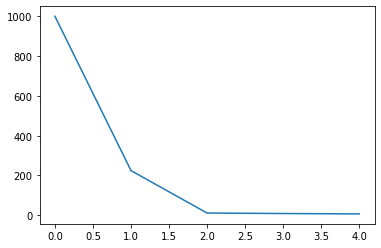

In [5]:
plt.plot(objectives)

# Dantzig-Wolfe Reformulation

The classical Dantzig-Wolfe situation is:
$$
\begin{matrix}
min & c_1 x_1 & + & c_2 x_2 & + & ... & + & c_K x_K         \\
s.t.& A_1 x_1 & + & A_2 x_2 & + & ... & + & A_K x_K & \ge b   & (1)\\
    & A_1 x_1 &   &         &   &     &   &         & \ge d_1 & (2)\\
    &         &   & A_2 x_2 &   &     &   &         & \ge d_2 & (2)\\
    &         &   & ... \\
    &         &   &         &   &     &   & D_K x_K & \ge d_K & (2)\\
\end{matrix}
$$

 * (1) Complicated/Coupling constraints
 * (2) "Easy to deal" constraints. Without the constraints (1), problem can be decomposed in K subproblems
 
![Dantzig-Wolfe Decomposition](https://upload.wikimedia.org/wikipedia/commons/e/ec/DW_Block_Angular_Matrix.jpg)

The idea is to apply [Minkowski-Weyl theorem](https://www.youtube.com/watch?v=J2mNuhlpDP8) on the “easy constraints” X = {x ≥ 0 | Dx ≥ d}. This theorem states that any feasible set of linear programming can be described equivalently by its extreme points and a finite set of directions.

![https://twitter.com/FrnkNlsn/status/1365223240835080193?s=20](minkowsky-weyl-theorem.jpeg)

In a convex polyhedron, x can be expressed as a linear combinaison of constraints Dx ≥ d.

For the Time constrained shortest path problem, the easy constraints are :
$
\sum_{(1,j) \in \mathcal{A}} x_{1j} = 1, (2) \\
\sum_{(i,j) \in \mathcal{A}} x_{ij} = \sum_{(j,i) \in \mathcal{A}} x_{ji}, (3) \\
\sum_{(i,6) \in \mathcal{A}} = 1, (4) \\
$
The convex hull of those constraints defines a polyhedron (in fact, a polytope) with integer vertices

 fact: every arc ﬂow can be represented as convex combination of path (and cycle) ﬂows

We have:
$$
\begin{matrix}
x_ij = & \sum_{p \in P} x_{pij} \lambda_p & \\
       & \sum_{p \in P} \lambda_p       & = 1, \textrm{Convexity constraint}
\end{matrix}
$$

# Branch-and-Bound: The Reformulation Repeats

# A Dual point of view

## Relation between Lagrangian Relaxation and Column Generation

Given the initial LP:

$$
\begin{matrix}
\max_x & z & = & Mx \\
s.t.   & & & \\
       & Ax & \le & b \\
       & x & \in & \{0, 1\}^{n}
\end{matrix}
$$


### Reformulation Lagrangian Relaxation

#### Primal

$$
\begin{matrix}
\max_x & z_{\text{LR}} & = & Mx  + \mu (b - Ax)\\
s.t.   & & & \\
       & x & \in & \{0, 1\}^{n}
       & \mu & \in & \mathbb{R}^{+m}
\end{matrix}
$$

#### Dual

$$
\begin{matrix}
\min_\mu & w_{\text{LR}} & = & Mx  + \mu (b - Ax)\\
s.t.   & & & \\
       & x & \in & \{0, 1\}^{n}
       & \mu & \in & \mathbb{R}^{+m}
\end{matrix}
$$

We can use multiple methods to optimize the dual (sub gradiant, ...).

#### Optimizing dual of Lagrangian Relaxation with cutting plane method

We solve the primal and the dual iteratively. At the k-th iteration, we have added k constraints to the dual:

$$
\begin{matrix}
\min_\mu & w_{\text{LR}}\\
s.t.   & & & \\
       & w_{\text{LR}} & \ge & Mx^k  + (\mu - \mu^{k-1}) (b - Ax^k) \\
       & \mu & \in & \mathbb{R}^{+m}
\end{matrix}
$$

With :
 * $x^k \in \{0, 1\}^{n}$ : the optimal solution of the primal at the k-th iteration
 * $\mu^{k-1}$ : the optimal solution of the dual at the k-1-th iteration

#### Dual of the cutting plane method

Let be $\pi^k$, the dual variable associated to the k-th constraint of the cutting plan PL:

$$
\begin{matrix}
\max_{\pi^k} & z_{\text{DCP}} = w_{\text{LR}} + \sum_k \pi^k [Mx^k  + (\mu - \mu^{k-1}) (b - Ax^k) - w_{\text{LR}}]\\
s.t.   & & & \\
       & \pi^k & \in & \mathbb{R}^+
\end{matrix}
$$

That can be rewritten as:
$$
\begin{matrix}
\max_{\pi^k} & z_{\text{DCP}} = \sum_k \pi^k Mx^k  + w_{\text{LR}} (1 - \sum_k \pi^k) +  \sum_k \pi^k (\mu - \mu^{k-1}) (b - Ax^k)\\
s.t.   & & & \\
       & \pi^k & \in & \mathbb{R}^+
\end{matrix}
$$

So that:
$$
\begin{matrix}
\max_{\pi^k} & z_{\text{DCP}} = M \sum_k \pi^k x^k \\
s.t.   &  & & \\
       & \sum_k \pi^k & = & 1 \\
       & A \sum_k \pi^k x^k & \le & b \sum_k \pi^k \\
       & \pi^k & \in & \mathbb{R}^+
\end{matrix}
$$

Which gives us the Column Generation formulation of the initial problem without the integrity constraint $x = \sum_k \pi^k x^k \in \mathbb{R}^{+n}$